anglesの型: <class 'list'>
anglesの最初の要素の型: <class 'list'>
anglesの最初の要素の内容: [356.0995062576181, 356.0090869015702, 355.9143832200251, 354.42780219603617, 353.2110254255612, 351.86989764584405, 350.5376777919744, 348.95905981967627, 347.9052429229879, 346.2930389959202, 344.9816393688493, 343.3007557660064, 341.9958383940866, 340.70995378081125, 339.44395478041656, 337.69379494509235, 336.44773632710536, 334.6538240580533, 333.434948822922, 332.24145939894, 331.0735741647464, 329.9314171781375, 328.8150253412616, 327.7243556854224, 327.03059609653786, 326.30993247402023, 324.4623222080256, 322.59464336859145, 320.71059313749964, 319.68589983950267, 318.81407483429035, 316.9091524329964, 315.93919094573556, 314.0608090542644, 312.18444331578877, 310.31410016049733, 308.453709216706, 306.6070748126075, 304.7778313663639, 303.69006752597977, 302.5740571345725, 300.7354877019201, 300.06858282186244, 298.9264258352536, 297.75854060106, 295.97439396243135, 294.77514056883194, 293.55226367289464,

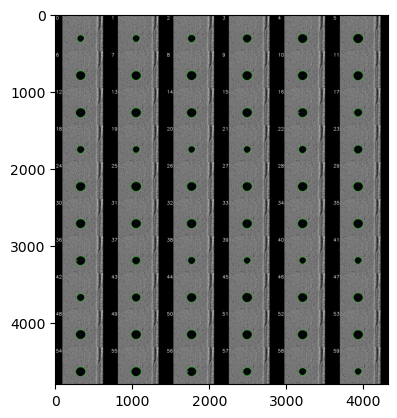

In [14]:
import cv2
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
import pixel_converter
from assemble_frames_with_order_numbers import assemble_frames_with_order_numbers
from table_image_generator import create_table_image, find_min_max_avg_table

def find_reference_point(contour, centroid):
    cx, cy = centroid
    reference_point = None
    min_y = float('inf')  # 最小のy座標値を見つけるために無限大で初期化
    for point in contour:
        x, y = point[0]
        if x == cx and y < cy:  # 重心の真上に位置する点を探す
            if y < min_y:  # より上に位置する点を見つけた場合
                min_y = y
                reference_point = (x, y)
    return reference_point

def draw_reference_point(image, centroid, reference_point):
    # 重心を赤い点で描画
    cv2.circle(image, centroid, 5, (0, 0, 255), -1)
    # 基準点（0度の点）を青い点で描画
    cv2.circle(image, reference_point, 5, (255, 0, 0), -1)
    return image
    
def calculate_angle_from_reference(contour, centroid, reference_point):
    angles = []
    cx, cy = centroid
    rx, ry = reference_point
    reference_angle = math.degrees(math.atan2(ry - cy, rx - cx))

    for point in contour:
        x, y = point[0]
        angle = math.degrees(math.atan2(y - cy, x - cx)) - reference_angle
        if angle < 0:
            angle += 360
        angles.append(angle)
    return angles

def draw_angle_points(image, contours, angles):
    target_angles = [0, 90, 180, 270]
    colors = [(255, 0, 0), (0, 255, 0), (0, 255, 255), (255, 0, 255)]

    for contour, angle_set in zip(contours, angles):
        for target_angle, color in zip(target_angles, colors):
            # 対象の角度に最も近い点を見つける
            closest_point_index = min(range(len(contour)), key=lambda i: abs(angle_set[i] - target_angle))
            closest_point = contour[closest_point_index]
            cv2.circle(image, tuple(closest_point[0]), 5, color, -1)

    return image


# ビデオデータの読み込み
filename = "C:\\Users\\flow\\Desktop\\bubbledate\\spherical bubbleGray.mp4"
base_path= "C:\\Users\\flow\\Desktop\\bubble_rasing_result\\"
# 動画ファイルのベース名を取得
video_base_name = os.path.splitext(os.path.basename(filename))[0]

# 動画ごとのディレクトリを作成
video_directory = os.path.join(base_path, video_base_name)
os.makedirs(video_directory, exist_ok=True)  # 既に存在している場合は作成しない
# 新しいフォルダのベース名を指定
folder_names = ["theta_image", "theta_contours", "theta_result", "theta_threshold", "theta_graph"]

# 新しいフォルダを作成
for folder_name in folder_names:
    new_folder_path = os.path.join(video_directory, folder_name)
    os.makedirs(new_folder_path, exist_ok=True)

# 動画の読み込み
cap = cv2.VideoCapture(filename=filename)
#動画ファイルの情報を取得する
width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
hight = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
total_frame = cap.get(cv2.CAP_PROP_FRAME_COUNT)
fps = cap.get(cv2.CAP_PROP_FPS)
# print("総フレーム数: ", total_frame)
# print("fps: ", fps)
# print("動画の長さ: ", total_frame/fps, "[sec]")
# 動画のdpiを取得
video_path = filename
dpi = pixel_converter.get_video_dpi(video_path)
# print(dpi)

frame_count = 0  # フレームのカウントを初期化
prev_cx = None  # 前のフレームの重心 x 座標
prev_cy = None  # 前のフレームの重心 y 座標
# グラフ用のデータ格納リスト
area_data = []
perimeter_data = []
moment_data = []
# 重心距離のデータを格納するリスト
centroid_distance_data = []
speed_data = []  # 速度情報を格納するリスト、最初の値を0に初期化
# 重心の座標を格納するリスト
centroid_x_list = []
centroid_y_list = []
centroid_data = []
radius_data = [] # 半径データを格納するためのリスト
# ㎜単位の速度情報を格納するリスト
speed_mm_per_s_data = []
# ㎜単位の重心y座標を格納するリスト
centroid_y_mm_data = []
# ㎜単位の気泡半径を格納するリスト
sphere_radius_mm_data = []
# フレームを格納するリスト
frames = []
# 水平方向と鉛直方向の気泡径のデータを格納するリスト
base_lengths = []
heights = []
base_length_mm_data = []
height_mm_data = []

# 開始フレームを設定
start_frame = 45  
# 開始フレームまで読み込む
for _ in range(start_frame):
    ret, _ = cap.read()
    if not ret:
        print("Error: Failed to read frames.")
        sys.exit(1)


while cap.isOpened() and frame_count < 60:  # 90枚分の処理を行う
    ret, frame = cap.read()
    if ret:   
        num = frame_count
        path = os.path.join(video_directory, "theta_image\\")
        contours_path = os.path.join(video_directory, "theta_contours\\")
        result_path = os.path.join(video_directory, "theta_result\\")
        threshold_path = os.path.join(video_directory, "theta_threshold\\")
        
        image_path = path + "picture{:0=3}.bmp".format(num)
        cv2.imwrite(image_path, frame)

        color_image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        if color_image is None:
            print(f"Error: Failed to load image from {image_path}")
            sys.exit(1)

        gray_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2GRAY)
        blurred_image = cv2.bilateralFilter(gray_image, 7, 15, 15 )
        ret, binary = cv2.threshold(blurred_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        thresholds_path = threshold_path + "threshold_picture{:0=3}.bmp".format(num)
        cv2.imwrite(thresholds_path, binary)

        raw_contours, _ = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        raw_img_with_contours = frame.copy()
        cv2.drawContours(raw_img_with_contours, raw_contours, -1, (0, 255, 0), 2)
        raw_contours_image_path = os.path.join(contours_path, "raw_contours_picture{:0=3}.bmp".format(num))
        cv2.imwrite(raw_contours_image_path, raw_img_with_contours)

        contours, _ = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        #print(contours)
        conditions = {
            "min_contour_area": 5000,
            "max_contour_area": 20000,
        }

        filtered_contours = []
        angles = []  # フレームごとにリセット
        area_data = []
        perimeter_data = []
        moment_data = []

        for idx, contour in enumerate(contours):
            contour_area = cv2.contourArea(contour)

            if (
                ("min_contour_area" not in conditions or contour_area >= conditions["min_contour_area"]) and
                ("max_contour_area" not in conditions or contour_area <= conditions["max_contour_area"])
            ):
                filtered_contours.append(contour)
                area_data.append(contour_area)
                perimeter_data.append(cv2.arcLength(contour, True))
                M = cv2.moments(contour)
                filtered_cx = int(M['m10'] / M['m00']) if M["m00"] != 0 else 0
                filtered_cy = int(M['m01'] / M['m00']) if M["m00"] != 0 else 0
                moment_data.append((filtered_cx, filtered_cy))
                
                # 角度計算
                cx, cy = int(M['m10'] / M['m00']), int(M['m01'] / M['m00'])
                reference_point = find_reference_point(contour, (cx, cy))
                contour_angles = calculate_angle_from_reference(contour, (cx, cy), reference_point)
                angles.append(contour_angles)
                
                # 輪郭上の点と重心の距離を計算し、最大距離を半径とし直径を求める
                max_radius = 0
                for point in contour:
                    x, y = point[0]
                    distance = math.sqrt((x - filtered_cx)**2 + (y - filtered_cy)**2)
                    if distance > max_radius:
                        max_radius = distance*2
                radius_data.append(max_radius)
                
                
        # anglesのデータ型を出力
        print("anglesの型:", type(angles))

        # anglesがリストの場合、その最初の要素の型と内容を出力
        if isinstance(angles, list):
            print("anglesの最初の要素の型:", type(angles[0]))
            print("anglesの最初の要素の内容:", angles[0])

            # anglesの各要素がリストであることを確認
            for angle_set in angles:
                if not isinstance(angle_set, list):
                    print("anglesの要素がリストではありません:", angle_set)
                else:
                    # anglesの各要素の長さを出力（各輪郭に対する角度の数）
                    print("角度の数:", len(angle_set))
        # 角度に基づいて元画像に点を描画
        theta_result_image = color_image.copy()
        annotated_image = draw_angle_points(theta_result_image, contours, angles)

        # 描画された画像を保存
        save_path = os.path.join(result_path, "annotated_picture{:0=3}.bmp".format(num))
        cv2.imwrite(save_path, annotated_image)      
        
        if len(filtered_contours) > 0:
            result_image = color_image.copy()
        
            for contour, moment in zip(filtered_contours, moment_data):
                x_coordinates = [point[0][0] for point in contour]
                y_coordinates = [point[0][1] for point in contour]
                
                min_x = min(x_coordinates)
                max_x = max(x_coordinates)
                min_y = min(y_coordinates)
                max_y = max(y_coordinates)
                base_length = max_x - min_x
                height = max_y - min_y

                base_lengths.append(base_length)
                heights.append(height)
                
                M = cv2.moments(contour)
                if M["m00"] != 0:
                    filtered_cx, filtered_cy = moment
                    area = cv2.contourArea(contour)
                    # 重心の座標をリストに追加
                    centroid_x_list.append(filtered_cx)
                    centroid_y_list.append(filtered_cy)
                    
                    
                    # 面積を描画
                    #cv2.putText(result_image, f"Area: {area}", (filtered_cx, filtered_cy), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
                    
                    # 重心に点を描画
                    cv2.circle(result_image, (filtered_cx, filtered_cy), 5, (0, 0, 255), -1)
                    # 輪郭を描画
                    cv2.drawContours(result_image, [contour], -1, (0, 255, 0), 2)
            
            result_image_path = os.path.join(result_path, "result_picture{:0=3}.bmp".format(num))
            frames.append(result_image)
            cv2.imwrite(result_image_path, result_image)
        
        # フレームごとに速度情報を格納
        if prev_cx is not None and prev_cy is not None:
            dx = filtered_cx - prev_cx
            dy = filtered_cy - prev_cy
            centroid_distance = math.sqrt(dx ** 2 + dy ** 2)
            centroid_distance_data.append(centroid_distance)
            dt = 1 / fps  # フレーム間の時間差（秒）
            speed_px_per_s = math.sqrt(dx ** 2 + dy ** 2) / dt
            speed_data.append(speed_px_per_s)
            
            # 重心のデータを追加
            centroid_data.append((filtered_cx, filtered_cy))
        
        # 前のフレームの重心を更新
        prev_cx = filtered_cx
        prev_cy = filtered_cy

        frame_count += 1
    else:
        break


cap.release()  # カメラリソースの解放
cv2.destroyAllWindows()  # ウィンドウの破棄

frame_list = frames  # フレームのリストをここに追加
output_image = assemble_frames_with_order_numbers(frame_list, rows=10, cols=6)
output_result = os.path.join(video_directory, "d_result", "output_image.jpg")
cv2.imwrite(output_result, output_image)
# 画像をジュピター上に表示
plt.imshow(output_image)
plt.show()





